In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from efficientnet_pytorch import EfficientNet

from sklearn.utils.class_weight import compute_class_weight

In [2]:
# upload train dataframe
train_df_allsamples = pd.read_csv("../TrainTestDataFrames/marking.csv")
train_df_allsamples.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [3]:
# create dictionary that maps image name to target 
image_names = train_df_allsamples["image_id"].values 
targets = train_df_allsamples["target"].values
img_to_target = {image_name:target for image_name, target in zip(image_names, targets)}

percent_tp = sum(targets)/len(targets) * 100 
print("{} training samples total.".format(len(targets)))
print("Only {:.3f} percent of training data set is a true positive.".format(percent_tp))
print("Therefore, the baseline accuracy is {:.3f}".format(np.max([percent_tp, 100-percent_tp])))

60487 training samples total.
Only 9.058 percent of training data set is a true positive.
Therefore, the baseline accuracy is 90.942


In [4]:
# update so that the number of positives balances negatives
train_df_pos = train_df_allsamples.iloc[targets>0, :]
train_df_neg = train_df_allsamples.iloc[targets==0, :]
train_df_negsample = train_df_neg.sample(n=int(train_df_pos.shape[0]))

# concatenate negative and positive samples, then shuffle using .sample() 
#train_val_df = pd.concat((train_df_pos, train_df_negsample)).sample(frac=1)
train_val_df = train_df_allsamples.sample(frac=.5)

train_val_split = .9
n_train_val = train_val_df.shape[0]
n_train = int(train_val_split*n_train_val)

train_df = train_val_df[:n_train]
val_df = train_val_df[n_train:]

# create dictionary that maps image name to target 
image_names = val_df["image_id"].values 
val_targets = val_df["target"].values

percent_tp = sum(val_targets)/len(val_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])

print("{} Training and {} Validation samples".format(n_train, n_train_val-n_train))
print("{:.3f} percent of validation data set is a positive.".format(percent_tp))
print("Baseline validation accuracy is {:.3f}".format(baseline))

27219 Training and 3025 Validation samples
8.628 percent of validation data set is a positive.
Baseline validation accuracy is 91.372


In [5]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [6]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform 
transform_1 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# horizontal or vertical flip 
transform_2 = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    #transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

def make_weights_for_balanced_classes(df, nclasses=2):   
    targets = df["target"].values
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[label] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[label]   
        
    return np.array(weight)  

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label_encode, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class MyDataLoader():
    def __init__(self, df, path, batchsize, min_balance=None):
        # store df, path, weights, ...
        self.df = df 
        self.path = path
        self.w = make_weights_for_balanced_classes(df)
        self.batchsize = batchsize 
        self.balanced = True
        self.min_balance = min_balance
        
        # create a dictionary to map image_ids to index and target in dataframe 
        image_ids = self.df['image_id'].values 
        self.targets = self.df['target'].values
        inds = np.arange(len(image_ids))
        self.imgID2Idx = {im_id:ind for (im_id, ind) in zip(image_ids, inds)}
        self.imgID2Target = {im_id:target for (im_id, target) in zip(image_ids, self.targets)}
        
        # keep track of how many times samples have been drawn 
        self.counts = np.zeros(len(image_ids))
        
    def get_batch(self):
        # get image ids for the batch 
        if np.sum(self.w > 0) >= self.batchsize:
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        else:
            # update batchsize 
            print("Updating batchsize, maximum dataset size reached")
            self.batchsize = np.sum(self.w > 0)
            batch_image_ids = self.df.sample(n=self.batchsize, weights=self.w)['image_id'].values
        
        # get the index locations for the image ids 
        batch_sample_inds = [self.imgID2Idx[im_id] for im_id in batch_image_ids]
        batch_targets = [self.imgID2Target[im_id] for im_id in batch_image_ids]
        
        # Update counts 
        self.counts[batch_sample_inds] += 1
        
        # Update sampling weights so that target=0 --> w = 0, target=1 --> w /= 2 
        for ind, target in zip(batch_sample_inds, batch_targets):
            # if the sample is a negative, then we don't want to sample it again 
            # if the sample has already been sampled 2 times, it shouldn't be sampled again
            # if target is positive, sampling should happen less frequently 
            if target == 0 or self.counts[ind] == 2:
                self.w[ind] = 0 
            else:
                self.w[ind] /= 2 
        
        # Data returned in shape [Batchsize, Channels, H, W]
        images = np.zeros((self.batchsize, 3, 256, 256)) 
        labels = np.zeros(self.batchsize)
        #meta_data = np.zeros((self.batchsize, 3))
        
        for i, index in enumerate(batch_sample_inds):
            
            # 1. load image
            img_name = self.df['image_id'].values[index]
            img_path = self.path + img_name + ".jpg"
            img = plt.imread(img_path)

            # 2. Preprocess the data (e.g. torchvision.Transform).
            img = Image.fromarray(img)
            if self.counts[index] == 1:
                images[i, :, :, :] = transform_1(img)
            if self.counts[index] == 2:
                images[i, :, :, :] = transform_2(img)

            # 3. store label 
            labels[i] = self.imgID2Target[img_name]
                
        # Quit once all positive samples have zero valued weights 
        if np.sum(self.w[self.targets==1]) == 0:
            self.balanced = False
            
        # If a min balance is specified, quit at min balance
        if self.min_balance:
            if sum(labels)/len(labels) <= self.min_balance:
                self.balanced = False
        
        # return data 
        X = torch.tensor(images, dtype = torch.float32)
        y = torch.tensor(labels, dtype = torch.float32)
        return X, y #, meta_data

In [7]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

Loaded pretrained weights for efficientnet-b0


In [8]:
# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=512)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(512, 2), 
                                    nn.Softmax(dim=1))
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)

In [9]:
# Train the model
# Use the prebuilt data loader.
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"
path_to_model = '../Models/ENETmodel.ckpt'

batchsize  = 26
# evaluate performance on validation data 
train_dataset = ValidDataset(train_df, path)                                              
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize) 

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=1) 


# Set training params (batchsize limited by GPU memory)
num_epochs = 50
min_balance = .25

# save losses from training 
train_roc = []
losses    = []

# save validation statistics 
val_roc = []
val_acc = []
val_precision = []
val_recall = []

patience     = 3
set_patience = 3 
best_val     = 0
verbose = True

# Loss and optimizer
class_weights = compute_class_weight(y=train_df['target'].values, class_weight='balanced', classes=np.unique(train_df['target'].values))
class_weights = torch.FloatTensor(class_weights).to(device)
    
criterion = nn.BCELoss(weight=class_weights)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler reduces learning rate by factor of 10 when val auc does not improve
scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)

for epoch in range(num_epochs):
    # set up model for training 
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        '''
        train_loader = MyDataLoader(train_df, path, batchsize=batchsize, min_balance=min_balance)
        while train_loader.balanced:
            images, labels = train_loader.get_batch()
        '''
        # make sure that there are some positive examples in the mini batch 
        n_pos = sum([l[1] for l in labels])
        if n_pos>0:
            
            images = images.to(device)
            #labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # store loss
            losses.append(loss)

            if i%50==0:
                # Calculate ROC
                predictions = np.array([p[1] for p in outputs.detach().cpu().numpy()])
                targets = np.array([p[1] for p in labels.cpu().numpy()])

                fpr, tpr, _ = roc_curve(np.array(targets, np.int), np.array(predictions).ravel())
                train_roc_auc = auc(fpr, tpr)
                train_roc.append(train_roc_auc)

                # Calculate balance 
                balance = np.sum(targets) / len(targets)

                print ('Epoch [{}/{}], Balance {:.2f}, Loss: {:.4f}, Train ROC AUC: {:.4f}' 
                       .format(epoch+1, num_epochs, balance, loss.item(), train_roc_auc))
        
    # prep model for evaluation
    valid_predictions = []
    valid_targets = []
    model.eval() 
    with torch.no_grad():
        for j, (images, labels) in enumerate(valid_loader):
            images = images.to(device)

            #labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate val ROC
            valid_predictions += [p[1] for p in outputs.detach().cpu().numpy()]
            valid_targets += [p[1] for p in labels.cpu().numpy()] 

    fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
    val_roc_epoch = auc(fpr, tpr)
    val_roc.append(val_roc_epoch)

    tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()
    val_acc_epoch = (tp + tn) / len(valid_targets)
    val_precision_epoch = tp / (tp + fp)
    val_recall_epoch = tp / (tp + fn)

    val_acc.append(val_acc_epoch)
    val_precision.append(val_precision_epoch)
    val_recall.append(val_recall_epoch)

    print ('\nEpoch [{}/{}], Val ROC AUC: {:.3f}, Val Acc: {:.3f}, Val Precision: {:.3f}, Val Recall {:.3f}\n'
           .format(epoch+1, num_epochs, val_roc_epoch, val_acc_epoch, val_precision_epoch, val_recall_epoch))
    
    # learning rate is reduced if val roc doesn't improve 
    scheduler.step(val_roc_epoch)
    
    if val_roc_epoch > best_val:
        best_val = val_roc_epoch
        patience = set_patience        
        torch.save(model.state_dict(), path_to_model)  
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
            model.load_state_dict(torch.load(path_to_model), strict=False)
            break

# Load best model 
model.load_state_dict(torch.load(path_to_model))

Epoch [1/50], Balance 0.12, Loss: 1.5114, Train ROC AUC: 0.6812
Epoch [1/50], Balance 0.08, Loss: 1.2922, Train ROC AUC: 0.5625
Epoch [1/50], Balance 0.08, Loss: 0.9346, Train ROC AUC: 0.9167
Epoch [1/50], Balance 0.23, Loss: 1.3143, Train ROC AUC: 0.8250
Epoch [1/50], Balance 0.04, Loss: 0.7944, Train ROC AUC: 0.8800


/home/jaron/anaconda3/lib/python3.5/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Epoch [1/50], Balance 0.00, Loss: 0.3598, Train ROC AUC: nan
Epoch [1/50], Balance 0.15, Loss: 1.4772, Train ROC AUC: 0.6477
Epoch [1/50], Balance 0.08, Loss: 0.9570, Train ROC AUC: 0.6667
Epoch [1/50], Balance 0.00, Loss: 0.3182, Train ROC AUC: nan
Epoch [1/50], Balance 0.08, Loss: 1.0088, Train ROC AUC: 0.5833
Epoch [1/50], Balance 0.04, Loss: 0.9337, Train ROC AUC: 0.1600
Epoch [1/50], Balance 0.12, Loss: 1.3803, Train ROC AUC: 0.5072
Epoch [1/50], Balance 0.08, Loss: 0.6327, Train ROC AUC: 0.7292
Epoch [1/50], Balance 0.08, Loss: 0.7599, Train ROC AUC: 0.6667
Epoch [1/50], Balance 0.15, Loss: 1.6433, Train ROC AUC: 0.6477
Epoch [1/50], Balance 0.15, Loss: 1.1334, Train ROC AUC: 0.8182
Epoch [1/50], Balance 0.04, Loss: 0.8577, Train ROC AUC: 0.3200
Epoch [1/50], Balance 0.12, Loss: 0.8881, Train ROC AUC: 0.7971
Epoch [1/50], Balance 0.12, Loss: 0.5019, Train ROC AUC: 0.9565
Epoch [1/50], Balance 0.15, Loss: 1.1565, Train ROC AUC: 0.7614
Epoch [1/50], Balance 0.08, Loss: 1.1666, Trai

Epoch [1/50], Balance 0.00, Loss: 0.1840, Train ROC AUC: nan
Epoch [1/50], Balance 0.12, Loss: 1.1274, Train ROC AUC: 0.6087
Epoch [1/50], Balance 0.04, Loss: 0.4680, Train ROC AUC: 0.8800
Epoch [1/50], Balance 0.12, Loss: 0.8109, Train ROC AUC: 0.7971
Epoch [1/50], Balance 0.23, Loss: 1.6265, Train ROC AUC: 0.9167
Epoch [1/50], Balance 0.15, Loss: 1.2712, Train ROC AUC: 0.7500
Epoch [1/50], Balance 0.08, Loss: 0.7904, Train ROC AUC: 0.8333
Epoch [1/50], Balance 0.04, Loss: 0.4903, Train ROC AUC: 0.8000
Epoch [1/50], Balance 0.08, Loss: 0.8021, Train ROC AUC: 0.6458
Epoch [1/50], Balance 0.15, Loss: 1.0593, Train ROC AUC: 0.8295
Epoch [1/50], Balance 0.08, Loss: 0.6404, Train ROC AUC: 0.7500
Epoch [1/50], Balance 0.00, Loss: 0.3697, Train ROC AUC: nan
Epoch [1/50], Balance 0.04, Loss: 0.6213, Train ROC AUC: 0.4800
Epoch [1/50], Balance 0.12, Loss: 0.9040, Train ROC AUC: 0.7391
Epoch [1/50], Balance 0.08, Loss: 0.5847, Train ROC AUC: 0.9375
Epoch [1/50], Balance 0.08, Loss: 0.6240, Trai

KeyboardInterrupt: 

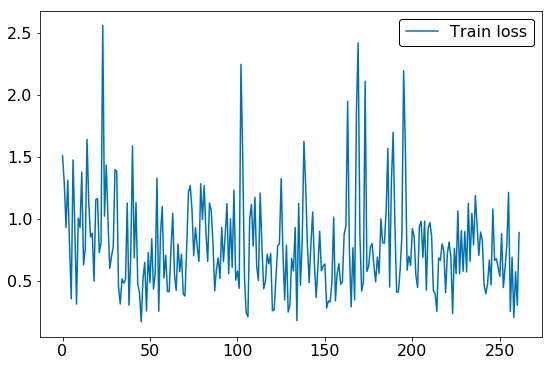

In [10]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(losses,label='Train loss')
plt.legend()
plt.show()

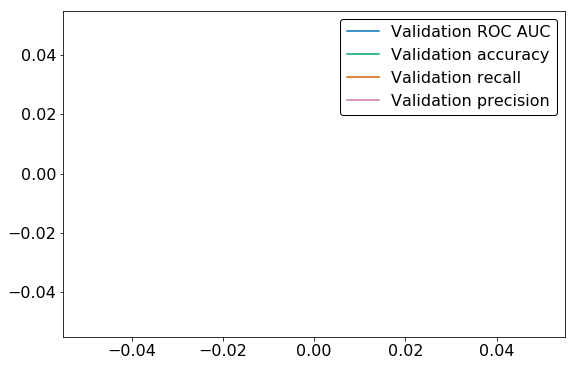

In [11]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.plot(val_roc, label = 'Validation ROC AUC')
plt.plot(val_acc, label = 'Validation accuracy')
plt.plot(val_recall, label = 'Validation recall')
plt.plot(val_precision, label = 'Validation precision')
plt.plot()
plt.legend()
plt.show()


Baseline classification accuracy: 91.37

Model classification accuracy:    91.64


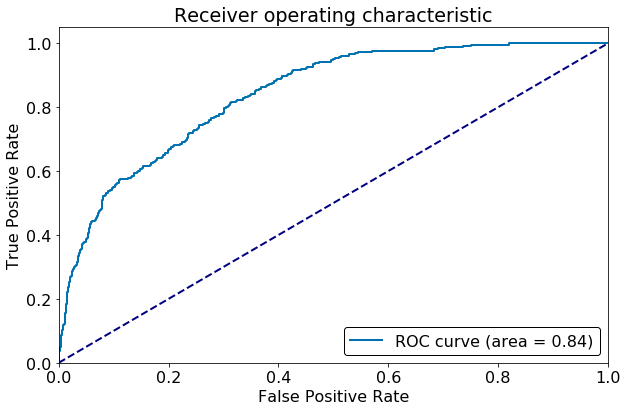

In [12]:
valid_predictions = []
valid_targets = []

model.eval() # prep model for evaluation
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
        images = images.to(device)

        #labels = torch.reshape(labels, [len(labels), 1])
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        valid_predictions += [p[1] for p in outputs.detach().cpu().numpy()]
        valid_targets += [p[1] for p in labels.cpu().numpy()] 

fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
roc_auc = auc(fpr, tpr)

percent_tp = sum(valid_targets)/len(valid_targets) * 100 
baseline = np.max([percent_tp, 100-percent_tp])
acc = 100 * np.sum(np.round(valid_predictions) == np.array(valid_targets)) / len(valid_targets)

print('\nBaseline classification accuracy: {:.2f}'.format(baseline))
print('\nModel classification accuracy:    {:.2f}'.format(acc))

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
np.sum(np.round(valid_predictions) == valid_targets) / len(valid_targets)

In [ ]:
tn, fp, fn, tp = confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())).ravel()

accuracy = (tp + tn) / len(valid_targets)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(np.array(valid_targets, np.int), np.round(np.array(valid_predictions).ravel())))

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(valid_predictions)
plt.xlabel("P(y=malignant | x)")
plt.show()

In [ ]:
#train_df.to_csv("ENET_train_df.csv", index=False)
#val_df.to_csv("ENET_val_df.csv", index=False)